# AWS Marketplace Product Usage Demonstration - Intel DAAL Algorithms

## Using Algorithm ARN with Amazon SageMaker APIs

This sample notebook demonstrates two new functionalities added to Amazon SageMaker:
1. Using an Algorithm ARN to run training jobs and use that result for inference
2. Using an AWS Marketplace product ARN - we will use [Intel® DAAL Decision Forest Regression ](https://aws.amazon.com/marketplace/pp/prodview-gymkpe7t47i36)

## Overall flow diagram
<img src="images/AlgorithmE2EFlow.jpg">

## Compatibility
This notebook is compatible only with [Intel® DAAL Decision Forest Regression ](https://aws.amazon.com/marketplace/pp/prodview-gymkpe7t47i36)

***Pre-Requisite:*** Please subscribe to this free product before proceeding with this notebook

## Set up the environment

In [1]:
import sagemaker as sage
from sagemaker import get_execution_role

role = get_execution_role()

### Create the session

The session remembers our connection parameters to Amazon SageMaker. We'll use it to perform all of our Amazon SageMaker operations.

In [54]:
sagemaker_session = sage.Session()

## Upload the data for training

When training large models with huge amounts of data, you'll typically use big data tools, like Amazon Athena, AWS Glue, or Amazon EMR, to create your data in S3. For the purposes of this example, we are using a Cycling Dataset for pyworkout-toolkit, and attempts to create a decision-forest regression model from the 5 features collected for telemetry to predict the user's Power output in the absence of a power meter.

We can use use the tools provided by the Amazon SageMaker Python SDK to upload the data to a default bucket. 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys

datafile_url="https://raw.githubusercontent.com/IntelPython/daal4py/master/examples/data/batch/cycling_dataset.csv"
training_data_file_prefix = 'data/training/'
training_data_file_raw = training_data_file_prefix + 'cycling_dataset.csv'

import subprocess
cmd = "wget -O " + training_data_file_raw + " " + datafile_url
subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)

print ("Saved: ", training_data_file_raw)


Saved:  data/training/cycling_dataset.csv


This example will be exploring workout data pulled from Strava, processed into a CSV for Pandas and daal4py usage.  Below, we utilize pandas to read in the CSV file, and look at the head of dataframe with .head()

In [50]:
workout_data_dd= pd.read_csv(training_data_file_raw, index_col=0)
workout_data_dd.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,185.800003,51,3.46,81,30.313309,-97.732711,45,3.459,2016-10-20T22:01:26.000Z
1,185.800003,68,7.17,82,30.313277,-97.732715,0,3.710,2016-10-20T22:01:27.000Z
2,186.399994,38,11.04,82,30.313243,-97.732717,42,3.874,2016-10-20T22:01:28.000Z
3,186.800003,38,15.18,83,30.313212,-97.732720,5,4.135,2016-10-20T22:01:29.000Z
4,186.600006,38,19.43,83,30.313172,-97.732723,1,4.250,2016-10-20T22:01:30.000Z


The data above has several key features that would be of great use here.  
- Altitude can affect performance, so it might be a useful feature.  
- Cadence is the revolutions per minute of the crank, and may have possible influence.  
- Heart Rate is a measure of the body's workout strain, and would have a high possibly of influence.
- Distance may have a loose correlation as it is highly route dependent, but might be possible.
- Speed has possible correlations as it ties directly into power.

## Explore and visualize some of the data

In general, we are trying to predict on the 'power' in Watts to see if we can generate a model that can predict one's power output without the usage of a cycling power meter.  Below are some basic scatterplots as we explore the data.  Scatterplots are great for looking for patterns and correlation in the data itself.  Below, we can see that cadence and speed are positively correlated.  

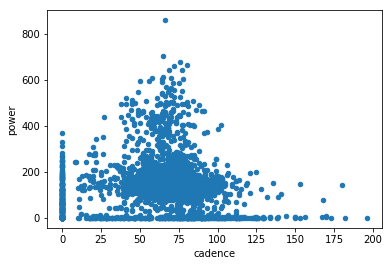

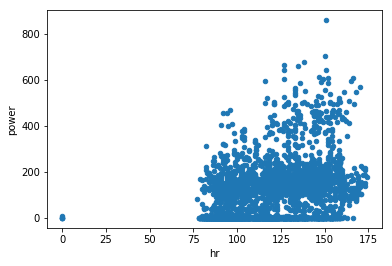

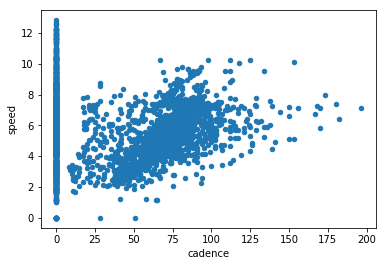

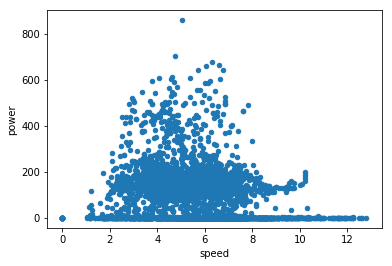

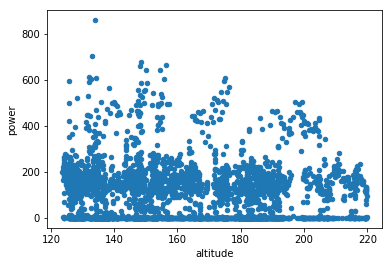

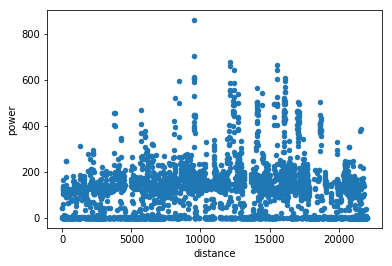

In [51]:
workout_data_dd.plot.scatter('cadence','power')
plt.show()
workout_data_dd.plot.scatter('hr','power')
plt.show()
workout_data_dd.plot.scatter('cadence','speed')
plt.show()
workout_data_dd.plot.scatter('speed','power')
plt.show()
workout_data_dd.plot.scatter('altitude','power')
plt.show()
workout_data_dd.plot.scatter('distance','power')
plt.show()

We will arrange it in a separate independent and dependent dataframes, then upload the training data and test data

In [52]:
print("workout_data_dd shape: ", workout_data_dd.shape)
train_set = workout_data_dd[0:3000]
test_set = workout_data_dd[3000:]
print("train_set shape:", train_set.shape, ", test_set shape:",test_set.shape)

# Reduce the dataset, create X.  We drop the target, and other non-essential features.
reduced_dataset = train_set.drop(['time','power','latitude','longitude'], axis=1)
# Get the target, create Y
target = train_set.power.values.reshape((-1,1))
# This is essentially doing np.array(dataset.power.values, ndmin=2).T
# as it needs to force a 2 dimensional array as we only have 1 target

#X is 5 features by 3k rows, Y is 3k rows by 1 column
print(reduced_dataset.values.shape, target.shape)
reduced_dataset = reduced_dataset.join(pd.DataFrame(target))
#reduced_dataset.values.shape

training_data_file = training_data_file_prefix + 'cycling_dataset_train.csv'
reduced_dataset.to_csv(training_data_file, sep=',', encoding='utf-8',index=False, header=None)
print ("Saved: ", training_data_file)

workout_data_dd shape:  (3902, 9)
train_set shape: (3000, 9) , test_set shape: (902, 9)
(3000, 5) (3000, 1)
Saved:  data/training/cycling_dataset_train.csv


In [25]:
# S3 prefix
bucket_name = 'rpanchum-us-east'
common_prefix = 'daal_df_regression'
data_key = common_prefix + '/train'

output_location = 's3://{}/{}'.format(bucket_name, data_key)
print ("Training artifacts will be uploaded at: " + output_location)

training_input = sagemaker_session.upload_data(training_data_file, bucket=bucket_name, key_prefix=data_key)
print ("Training Data uploaded at: " + training_input)

Training artifacts will be uploaded at: s3://rpanchum-us-east/daal_df_regression/train
Training Data uploaded at: s3://rpanchum-us-east/daal_df_regression/train/cycling_dataset_train.csv


## Creating Training Job using Algorithm ARN

Please put in the algorithm arn you want to use below. This can either be an AWS Marketplace algorithm you subscribed to (or) one of the algorithms you created in your own account.

The algorithm arn listed below belongs to the Intel DAAL Decision Forest Regression.

In [53]:
algorithm_arn = "arn:aws:sagemaker:us-east-2:057799348421:algorithm/intel-daal-decision-forest-reg-534506b2ea74137db3cf410baa55bfc7"
print (algorithm_arn)

arn:aws:sagemaker:us-east-2:057799348421:algorithm/intel-daal-decision-forest-reg-534506b2ea74137db3cf410baa55bfc7


In [23]:
import json
import time
from sagemaker.algorithm import AlgorithmEstimator

algo = AlgorithmEstimator(
            algorithm_arn=algorithm_arn,
            role=role,
            train_instance_count=1,
            train_instance_type='ml.c4.xlarge',
            base_job_name='intel-daal-df-reg-from-aws-marketplace',
            hyperparameters={"nTrees":"100", 
                            "varImportance":"MDA_Raw", 
                            "bootstrap":"True", 
                            "resultsToCompute":"computeOutOfBagError|computeOutOfBagErrorPerObservation" } 
)

## Run Training Job

In [24]:
print ("Now run the training job using algorithm arn %s in region %s" % (algorithm_arn, sagemaker_session.boto_region_name))
algo.fit({'training': training_input})

Now run the training job using algorithm arn arn:aws:sagemaker:us-east-2:057799348421:algorithm/intel-daal-decision-forest-reg-534506b2ea74137db3cf410baa55bfc7 in region us-east-2


INFO:sagemaker:Creating training-job with name: intel-daal-df-reg-from-aws-marketplace-2018-11-29-08-35-22-697


2018-11-29 08:35:23 Starting - Starting the training job...
2018-11-29 08:35:24 Starting - Launching requested ML instances...
2018-11-29 08:36:23 Starting - Preparing the instances for training.........
2018-11-29 08:37:35 Downloading - Downloading input data...
2018-11-29 08:38:21 Training - Training image download completed. Training in progress.
2018-11-29 08:38:21 Uploading - Uploading generated training model
2018-11-29 08:38:21 Completed - Training job completed

2018-11-29 08:38:10 INFO     Container setup completed, In Docker entrypoint - train... 
2018-11-29 08:38:10 INFO     Default Hyperparameters loaded: 
2018-11-29 08:38:10 INFO     
{'bootstrap': 'True',
 'distributed': 'False',
 'featuresPerNode': '0',
 'fptype': 'double',
 'impurityThreshold': '0',
 'maxTreeDepth': '0',
 'memorySavingMode': 'False',
 'method': 'defaultDense',
 'minObservationsInLeafNode': '5',
 'nTrees': '100',
 'observationsPerTreeFraction': '1',
 'resultsToCompute': '0',
 'seed': '777',
 'varImportan

## Automated Model Tuning (optional)

Since this algorithm supports tunable hyperparameters with a tuning objective metric, we can run a Hyperparameter Tuning Job to obtain the best training job hyperparameters and its corresponding model artifacts. 

<img src="images/HPOFlow.jpg">


In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter

## This demo algorithm supports max_leaf_nodes as the only tunable hyperparameter.
hyperparameter_ranges = {'max_leaf_nodes': IntegerParameter(1, 100000)}

tuner = HyperparameterTuner(estimator=algo, base_tuning_job_name='some-name',
                                objective_metric_name='validation:accuracy',
                                hyperparameter_ranges=hyperparameter_ranges,
                                max_jobs=2, max_parallel_jobs=2)

tuner.fit({'training': training_input}, include_cls_metadata=False)
tuner.wait()

## Batch Transform Job

Now let's use the model built to run a batch inference job and verify it works.

### Batch Transform Input Preparation

The snippet below is removing the "label" column (column indexed at 0) and retaining the rest to be batch transform's input. 

Now that the model is trained, we can test it with the test part of the dataset.  We drop the same features to match that of the trained model.

Now that the model is trained, we can test it with the test part of the dataset.  We drop the same features to match that of the trained model, and put it into daal4py's linear_regression_prediction class.

In [32]:
subset = test_set.drop(['time','power','latitude','longitude'], axis=1)
subset.head()

,altitude,cadence,distance,hr,speed
230,201.199997,51,17160.470703,169,3.070
231,201.600006,49,17163.449219,168,2.990
232,201.000000,47,17166.400391,168,2.957
233,201.199997,46,17169.359375,167,2.957
234,203.800003,46,17172.550781,166,3.168


In [36]:
test_data_file_prefix = 'data/test/'
test_data_file = test_data_file_prefix + 'cycling_dataset_test.csv'

subset.to_csv(test_data_file, sep=',', encoding='utf-8',index=False, header=None)
print ("Saved: ", test_data_file)

Saved:  data/test/cycling_dataset_test.csv


In [37]:
# S3 prefix
bucket_name = 'rpanchum-us-east'
data_key = common_prefix + '/transform'

transform_output_location = 's3://{}/{}'.format(bucket_name, data_key)
print ("Transform artifacts will be uploaded to: " + transform_output_location)

transform_input = sagemaker_session.upload_data(test_data_file, bucket=bucket_name, key_prefix=data_key)
print("Transform input uploaded to " + transform_input)


Transform artifacts will be uploaded to: s3://rpanchum-us-east/daal_df_regression/transform
Transform input uploaded to s3://rpanchum-us-east/daal_df_regression/transform/cycling_dataset_test.csv


In [38]:
transformer = algo.transformer(1, 'ml.c4.xlarge')
transformer.transform(transform_input, content_type='text/csv')
transformer.wait()

print("Batch Transform output saved to " + transformer.output_path)

INFO:sagemaker:Creating model package with name: intel-daal-decision-forest-reg-534506b2-2018-11-29-08-48-56-840


..........

INFO:sagemaker:Creating model with name: intel-daal-decision-forest-reg-534506b2-2018-11-29-08-49-42-449


INFO:sagemaker:Creating transform job with name: intel-daal-df-reg-from-aws-marketplace-2018-11-29-08-49-42-680


..................................!
Batch Transform output saved to s3://sagemaker-us-east-2-927702822156/intel-daal-df-reg-from-aws-marketplace-2018-11-29-08-49-42-680


#### Inspect the Batch Transform Output in S3

In [39]:
from urllib.parse import urlparse

parsed_url = urlparse(transformer.output_path)
bucket_name = parsed_url.netloc
file_key = '{}/{}.out'.format(parsed_url.path[1:], "cycling_dataset_test.csv")

s3_client = sagemaker_session.boto_session.client('s3')

response = s3_client.get_object(Bucket = sagemaker_session.default_bucket(), Key = file_key)
response_bytes = response['Body'].read().decode('utf-8')
print(response_bytes)

5.849137381015305692e+01
5.743458913740338545e+01
6.035705234086624671e+01
5.632658913740338136e+01
5.632658913740338136e+01
5.746181207423839510e+01
5.811837485168909723e+01
5.823805219022982982e+01
5.930591568829068905e+01
5.960249716854292501e+01
5.930591568829068905e+01
5.930591568829068905e+01
5.930591568829068905e+01
5.895905994599377209e+01
5.895905994599377209e+01
5.895905994599377209e+01
5.960249716854292501e+01
5.930591568829068905e+01
5.930591568829068905e+01
5.930591568829068905e+01
5.960249716854292501e+01
5.960249716854292501e+01
5.960249716854292501e+01
6.008121668073804500e+01
6.008121668073804500e+01
6.008121668073804500e+01
5.970565225226559392e+01
5.970565225226559392e+01
6.336109882424520379e+01
5.970565225226559392e+01
5.970565225226559392e+01
5.970565225226559392e+01
6.696237368748303709e+01
6.829076578688103893e+01
7.043216774811949676e+01
7.196836277872110088e+01
6.725397952004303193e+01
6.802961944541772255e+01
6.760761944541764024e+01
6.802961944541772255e+01


## Live Inference Endpoint

Finally, we demonstrate the creation of an endpoint for live inference using this AWS Marketplace algorithm generated model


In [40]:
from sagemaker.predictor import csv_serializer
predictor = algo.deploy(1, 'ml.m4.xlarge', serializer=csv_serializer)

INFO:sagemaker:Creating model package with name: intel-daal-decision-forest-reg-534506b2-2018-11-29-08-53-16-635


..........

INFO:sagemaker:Creating model with name: intel-daal-decision-forest-reg-534506b2-2018-11-29-08-54-02-280


INFO:sagemaker:Creating endpoint with name intel-daal-df-reg-from-aws-marketplace-2018-11-29-08-35-22-697


--------------------------------------------------------------!

### Choose some data and use it for a prediction

Now we can create the Prediction object and use the reduced dataset for prediction.  The class's arguments use the independent data and the trained model from above as the parameters.

In [41]:
subset.head()

,altitude,cadence,distance,hr,speed
230,201.199997,51,17160.470703,169,3.070
231,201.600006,49,17163.449219,168,2.990
232,201.000000,47,17166.400391,168,2.957
233,201.199997,46,17169.359375,167,2.957
234,203.800003,46,17172.550781,166,3.168


Prediction is as easy as calling predict with the predictor we got back from deploy and the data we want to do predictions with. The serializers take care of doing the data conversions for us.

In [46]:
print(predictor.predict(subset.values[20:25,:]).decode('utf-8'))

5.960249716854292501e+01
5.960249716854292501e+01
5.960249716854292501e+01
6.008121668073804500e+01
6.008121668073804500e+01



### Cleanup the endpoint

In [47]:
algo.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: intel-daal-df-reg-from-aws-marketplace-2018-11-29-08-35-22-697
